<a href="https://colab.research.google.com/github/Amr0093/Amr0093/blob/main/Natural_Language_Processing_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Many thanks to shahules at Kaggle https://www.kaggle.com/shahules


Important refrence to understand the capability of the Gensim tool https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/

In [ ]:
import os
user = 'amrahmed93'
key = 'e046f1a9930f5caf3b73e3d4c96317b2'
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started -p /content/sample_data/Disaster_tweets

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 132MB/s]


In [ ]:
!unzip /content/sample_data/Disaster_tweets/nlp-getting-started.zip -d /content/sample_data/Disaster_tweets

Archive:  /content/sample_data/Disaster_tweets/nlp-getting-started.zip
  inflating: /content/sample_data/Disaster_tweets/sample_submission.csv  
  inflating: /content/sample_data/Disaster_tweets/test.csv  
  inflating: /content/sample_data/Disaster_tweets/train.csv  


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_colwidth',200)

In [ ]:
df= pd.read_csv('/content/sample_data/Disaster_tweets/train.csv')
test_data=pd.read_csv('/content/sample_data/Disaster_tweets/test.csv')

In [ ]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Explore all the feature and basic details about the data 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
df.columns # after using the .info i don't think that it's needed to find the labels

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [ ]:
f= ['keyword', 'location', 'target']

## The following step is only existing in the train dataset and not the test dataset

0    4342
1    3271
Name: target, dtype: int64
Total Number: 7613


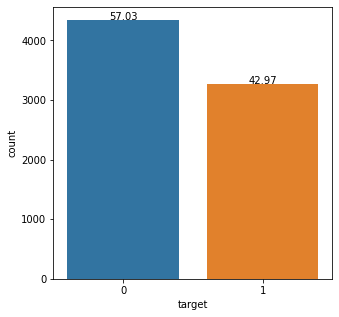

In [ ]:
# Identifying label data from the whole datset and visualising label counts and display % of data as annotations

plt.figure(figsize=(5,5))

ax = sn.countplot(x="target", data=df)
for p in ax.patches:#displaying % as annotations
        ax.annotate(round(100*p.get_height()/len(df),2), (p.get_x()+0.3, p.get_height()+2))
        # P is means the rectangle shape # the height of the rectangle means the number of 1 or 0 then it'll be divided by len(df) to get the
        # percentage and multiply it by 100 # after the comma is the x position then another comma and the y position 

print(df.target.value_counts())
print("Total Number:",sum(df.target.value_counts()))

## We have a dataset with plenty of both labels to analyze and make a decent model.

In [ ]:
sn.set(style='darkgrid')
plt.figure(figsize=(25,75))
sn.countplot(y = 'keyword',
              data = df,
              order = df['keyword'].value_counts().index)
plt.show()

print(df.keyword.value_counts())

In [ ]:
print(df.location.value_counts())

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64


In [ ]:
df=df[['text','target']]
df.isnull().sum()

text      0
target    0
dtype: int64

In [ ]:
# Defining Train and Validation sets
from sklearn.model_selection import train_test_split
data=df
X = data.text.values
y = data.target.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=101)

In [ ]:
indexNames = test_data[test_data['text'].isnull()].index
print(indexNames)

# Keep important columns
test_data = test_data[['id', 'text']]

# Display 5 samples from the test data
test_data.sample(5)

Int64Index([], dtype='int64')


,id,text
3252,10836,#Ebola #EbolaOutbreak Ebola Virus: Birmingham Ala. Firefighters Quarantined After Possible Exposure Officials Say http://t.co/tjpYlU9fOX
173,562,RT @an_opus: Elliott will be on probation for two years and will have to pay fines up to $1179. http://t.co/72bcyfbTj3
2536,8466,@theboysftvines oh my god i SCREAMED WHEN I SAW THIS YESSSS
2854,9462,Combating #fear of #terrorismturn off your tv &amp;Veterans For Peace Calls 4 an End 2 #NATO #VFP http://t.co/YPPG4kZIpS http://t.co/cBfdI6LF2X
79,275,Shot 12 times. Found dead in cuffs after being involved in a car accident. Officers told ambulance not to treat him. https://t.co/MEUDJwaaNg


## Natural language preprocessing 

In [ ]:
import nltk
#download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])


In [ ]:
type(X_train_preprocessed)

numpy.ndarray

In [ ]:
# X_train_preprocessed.random(3)
print(np.random.choice(X_train_preprocessed, size=8))

['fitness knee damage solution http co pumbrnebje' 'wild fires west crazy'
 'http co 3sth9lrbun photos flames rage manchester buildings 3 alarm fire http co jqxm4gcqz3 nh1news'
 'would black dude antioch would rioting'
 'ever since kelly burned keep dreams inside burning buildings ? ?'
 'iranian warship points weapon u helicopter official says http co snqfhpym3o tcot'
 'sure burned 100 calories eating giant bowl mac cheese totally earned 300 calorie klondike bar'
 'science daily lightning reshapes rocks atomic level lightning strike can reshape mineral crystal http co tezltqeyw2']


In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 10.5 s, sys: 1.34 s, total: 11.8 s
Wall time: 11.8 s


In [ ]:
type(X_train_tfidf)
X_train_tfidf.get_shape()

(6851, 116951)

In [ ]:
y_train.shape

(6851,)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# Define our multinomialNB model with and alpha of 0.1, we did try varying the alpha and at 0.2 already the accuracy is falling down 
model=MultinomialNB(alpha = 0.1)

model.fit(X_train_tfidf, y_train)

labels = model.predict(X_val_tfidf)

#Check the accuracy of our MultinomialNB classifier
score = metrics.accuracy_score(y_val,labels,normalize=True)
print("accuracy: %0.3f" % score)

accuracy: 0.793


              precision    recall  f1-score   support

     label 0       0.79      0.88      0.83       442
     label 1       0.80      0.68      0.73       320

    accuracy                           0.79       762
   macro avg       0.79      0.78      0.78       762
weighted avg       0.79      0.79      0.79       762

[[387  55]
 [103 217]]


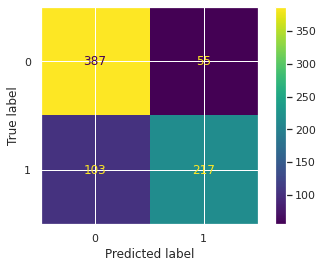

In [ ]:
print(metrics.classification_report(y_val,labels,target_names=['label 0','label 1']))
print(metrics.confusion_matrix(y_val, labels))
plot_confusion_matrix(model,X_val_tfidf,y_val);

We have created a base model using MultinomialNB with an accuracy of 0.80 at an alpha of 0.27, the precision and recall also seems to be quiet fine.

Now we will try to build another model using the library autoviml.

In [ ]:
!pip install autoviml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 7.3 MB/s 
     |████████████████████████████████| 76.8 MB 1.3 MB/s 
     |████████████████████████████████| 268 kB 59.0 MB/s 
     |████████████████████████████████| 569 kB 57.6 MB/s 
     |████████████████████████████████| 125 kB 58.7 MB/s 
     |████████████████████████████████| 216 kB 53.6 MB/s 
     |████████████████████████████████| 255.9 MB 46 kB/s 
     |████████████████████████████████| 11.2 MB 46.5 MB/s 
     |████████████████████████████████| 960 kB 68.3 MB/s 
     |████████████████████████████████| 1.6 MB 63.1 MB/s 
     |████████████████████████████████| 120 kB 47.4 MB/s 
     |████████████████████████████████| 82 kB 729 kB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=3b4c01fb4042d4dab634c9f60485436937a221ebfa906ac9938941794e486b20
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51

## Model 2 Using Decision Trees via Autoviml library

In [ ]:
from sklearn.model_selection import train_test_split

from autoviml.Auto_NLP import Auto_NLP

train, test = train_test_split(df, test_size=0.2)

Imported Auto_ViML version: 0.1.710. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Auto NLP processing on NLP Column: text
Shape of Train Data: 6090 rows
    Shape of Test Data: 1523 rows


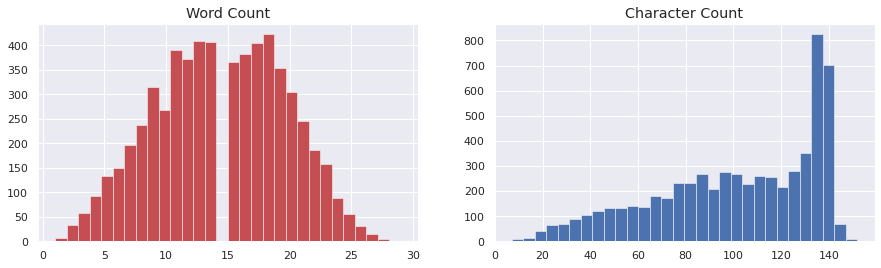

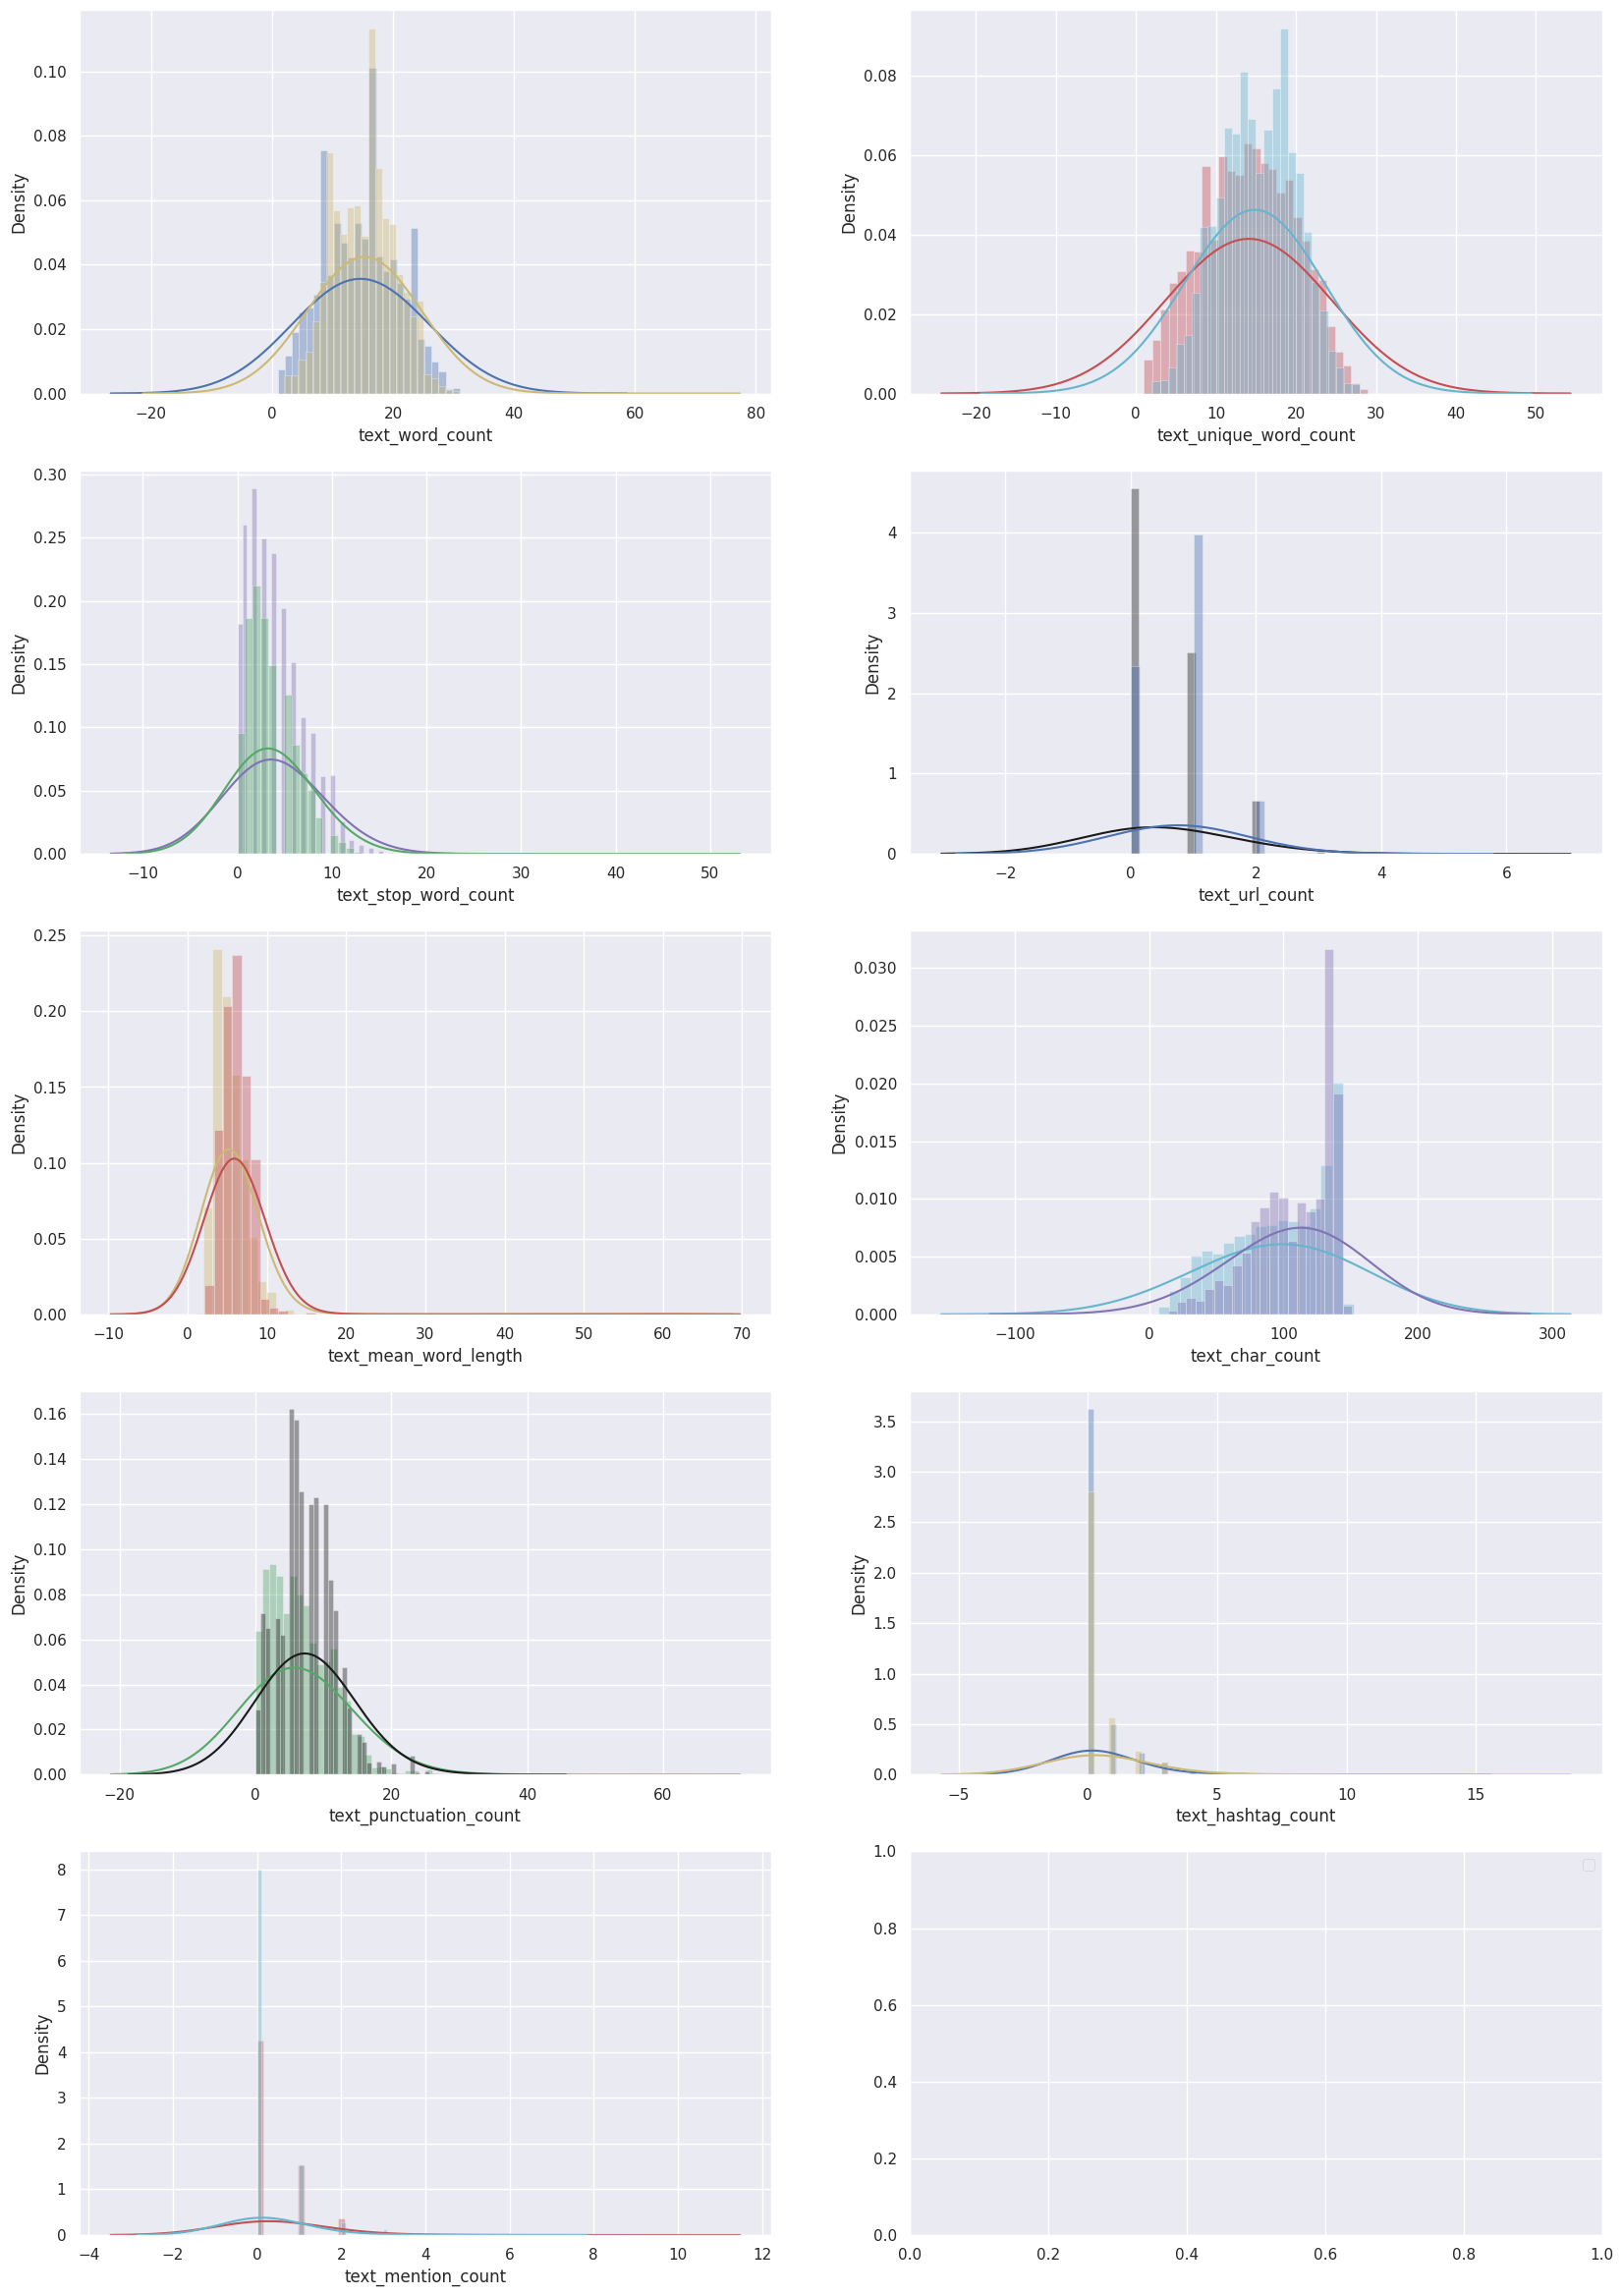

    Added 9 summary columns for counts of words and characters in each row
Cleaning text in Train data for text column
    Faster text processing using clean_tweets function, since top_num_features exceeds 300
Train data Text cleaning completed. Time taken = 16 seconds

For target = target

    For class = 0
Top 200 n-grams
: ['not', 'like', 'do', 'me', 'will', 'but', 'your', 'if', 'what', 'new', 'he', 'amp', 'ha', 'scream', 'now', 'we', 'no', 'when', 'go', 'they', 'there', 'how', 'love', 'as', 'would', 'bodi', 'time', 'video', 'bag', 'see', 'burn', 'day', 'let', 'obliter', 'whi', 'want', 'know', 'make', 'look', 'feel', 'laugh', 'come', 'fuck', 'peopl', 'fire', 'loud', 'youtub', 'been', 'back', 'crush', 'off', 'drown', 'wreck', 'emerg', 'think', 'explod', 'bomb', 'cannot', 'need', 'them', 'good', 'her', 'fatal', 'world', 'after', 'take', 'had', 'thank', 'work', 'full', 'who', 'did', 'surviv', 'ass', 'she', 'demolish', 'destroy', 'im', 'man', 'smoke', 'first', 'our', 'death', 'way', 'go

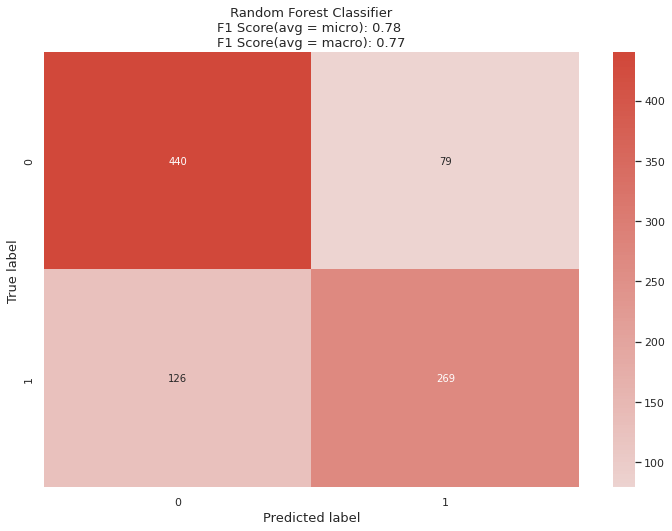

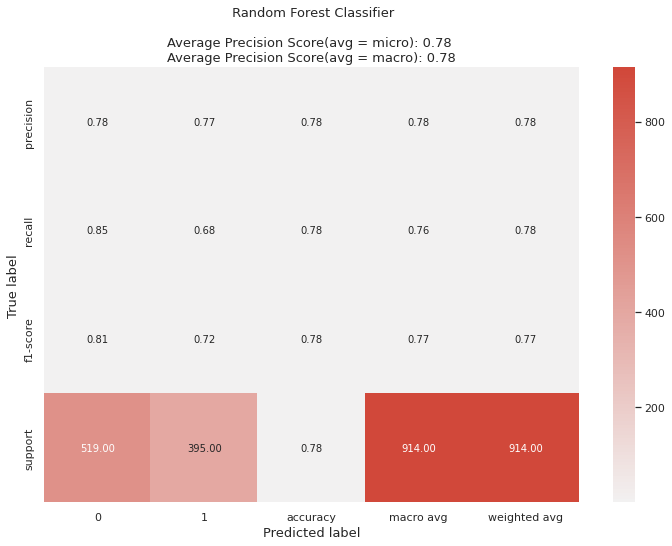

  Now transforming Train data to return as output...
  Transforming Test data to return as output...
Training best Auto_NLP Pipeline on full Train data...will be faster since best params are known
    Returning best Auto_NLP pipeline to transform and make predictions on test data...
Training completed. Time taken for Auto_NLP = 15.7 minutes


In [ ]:
input_feature, target = "text", "target"
train_x, test_x, final, predicted= Auto_NLP(input_feature, train, test,target,
                                            score_type="weighted-f1",
                                            top_num_features=399,
                                            modeltype="Classification",
                                            verbose=2,
                                            build_model=True)

We have built Model 1 using Multinomila NB with alpha = 0.27 and accuracy of 0.797
So now we do have a trained random forest classifier using AutoNLP feature from Autoviml library with a Average Precision Score(avg=macro): 0.80
We will get down to using a BERT model, already pretrained on huge data, we will retrain the model with our own dataset.
4) Advanced Modelling :
Fine-tuning BERT for Tweets Analysis
Originally borrowed from https://colab.research.google.com/drive/1f32gj5IYIyFipoINiC8P3DvKat-WWLUK

References:

The Illustrated BERT, ELMo, and co.: A very clear and well-written guide to understand BERT.
The documentation of the transformers library
BERT Fine-Tuning Tutorial with PyTorch by Chris McCormick: A very detailed tutorial showing how to use BERT with the HuggingFace PyTorch library.